In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from Datasets import load
from torch.utils.data import DataLoader
from model import Conv_Net_Dropout, Conv_Net_FC_Dropout, Conv_Net
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [45]:
model = Conv_Net_FC_Dropout()
model.load_state_dict(torch.load('/home/julius/OOD/models/model3_drop_fc_0_5.pth'))
model.to('cuda')
model.eval()

Conv_Net_FC_Dropout(
  (convs): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (7): ReLU()
  )
  (fcs): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=3136, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=128, out_features=10, bias=True)
    (5): Softmax(dim=1)
  )
)

In [46]:
mnist_dataset = load('MNIST')(train = False)
mnist_loader = DataLoader(mnist_dataset, batch_size = 128, shuffle = False)

cifar_dataset = load('CIFAR10')(train = False)
cifar_loader = DataLoader(cifar_dataset, batch_size = 128, shuffle = False)

Files already downloaded and verified


In [57]:
with torch.no_grad():
    mnist_softmax = []
    for x, y in tqdm(mnist_loader):
        x = x.to('cuda')
        out = model(x)
        mnist_softmax.append(torch.max(out.cpu(), dim = 1)[0])
    mnist_softmax = torch.cat(mnist_softmax).numpy()


100%|██████████| 79/79 [00:01<00:00, 55.65it/s]


In [58]:
mnist_softmax

[tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9998,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         0.7426, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0

(10000,)

In [34]:
with torch.no_grad():
    cifar_softmax = []
    for x, y in tqdm(cifar_loader):
        x = x.to('cuda')
        out = model(x)
        cifar_softmax.append(torch.max(out.cpu()))
    cifar_softmax = torch.tensor(cifar_softmax).numpy()

100%|██████████| 79/79 [00:00<00:00, 79.13it/s]


In [44]:
print('MNIST min and max:', np.min(mnist_softmax), np.max(mnist_softmax))
print('CIFAR min and max:', np.min(cifar_softmax), np.max(cifar_softmax))

MNIST min and max: 1.0 1.0
CIFAR min and max: 0.99143434 1.0


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False])

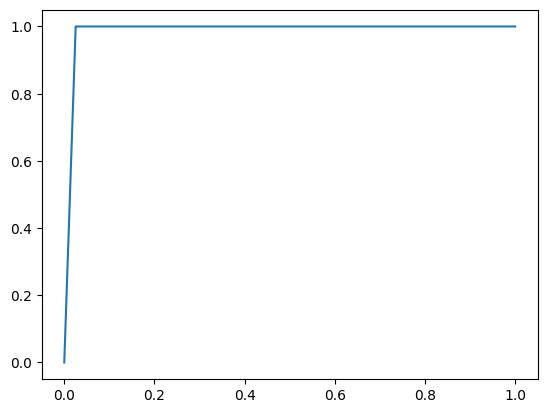

In [42]:
fpr,tpr, thresholds = roc_curve(np.concatenate((np.zeros_like(cifar_softmax),np.ones_like(mnist_softmax))),np.concatenate(( cifar_softmax, mnist_softmax)))
plt.plot(fpr, tpr)

In [43]:
print('AUC:', auc(fpr,tpr))

AUC: 0.9873417721518987
